Root Mean Square Error (RMSE) - Método de Erro utilizado nesse modelo

Usaremos os datasets do Movie Lens 100k

<H1>Corpo

<H3> Imports

In [2]:
import numpy as np
import pandas as pd
from scipy import spatial

In [3]:
from surprise import Dataset
from surprise import Reader

In [4]:
from sklearn.neighbors import NearestNeighbors

In [108]:
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

<H2> Teste com pequenos dados

In [5]:
a = [1, 2]
b = [2, 4]
c = [2.5, 4]
d = [4.5, 5]

Testando a distância euclidiana

In [6]:
print(f'Distância euclidiana entre c e a {spatial.distance.euclidean(c, a)}')
print(f'Distância euclidiana entre c e b {spatial.distance.euclidean(c, b)}')
print(f'Distância euclidiana entre c e d {spatial.distance.euclidean(c, d)}')

Distância euclidiana entre c e a 2.5
Distância euclidiana entre c e b 0.5
Distância euclidiana entre c e d 2.23606797749979


Testando a distância de cossenos

In [7]:
print(f'Distância de cossenos entre c e a {spatial.distance.cosine(c, a)}')
print(f'Distância de cossenos entre c e b {spatial.distance.cosine(c, b)}')
print(f'Distância de cossenos entre c e d {spatial.distance.cosine(c, d)}')
print(f'Distância de cossenos entre a e b {spatial.distance.cosine(a, b)}')

Distância de cossenos entre c e a 0.004504527406047898
Distância de cossenos entre c e b 0.004504527406047898
Distância de cossenos entre c e d 0.015137225946083022
Distância de cossenos entre a e b 0.0


<H4> Nota sobre similaridade de cossenos

To factor in such individual user preferences, you will need to bring all users to the same level by removing their biases. You can do this by subtracting the average rating given by that user to all items from each item rated by that user. Here’s what it would look like:

For user A, the rating vector [1, 2] has the average 1.5. Subtracting 1.5 from every rating would give you the vector [-0.5, 0.5].
For user B, the rating vector [2, 4] has the average 3. Subtracting 3 from every rating would give you the vector [-1, 1].
By doing this, you have changed the value of the average rating given by every user to 0. Try doing the same for users C and D, and you’ll see that the ratings are now adjusted to give an average of 0 for all users, which brings them all to the same level and removes their biases.

The cosine of the angle between the adjusted vectors is called centered cosine. This approach is normally used when there are a lot of missing values in the vectors, and you need to place a common value to fill up the missing values.

Filling up the missing values in the ratings matrix with a random value could result in inaccuracies. A good choice to fill the missing values could be the average rating of each user, but the original averages of user A and B are 1.5 and 3 respectively, and filling up all the empty values of A with 1.5 and those of B with 3 would make them dissimilar users.

But after adjusting the values, the centered average of both users is 0, which allows you to capture the idea of the item being above or below average more accurately for both users with all missing values in both user’s vectors having the same value 0.

Euclidean distance and cosine similarity are some of the approaches that you can use to find users similar to one another and even items similar to one another. (The function used above calculates cosine distance. To calculate cosine similarity, subtract the distance from 1.)

<H4> Similaridade R

O rating de similaridade dos N usuários similares a U

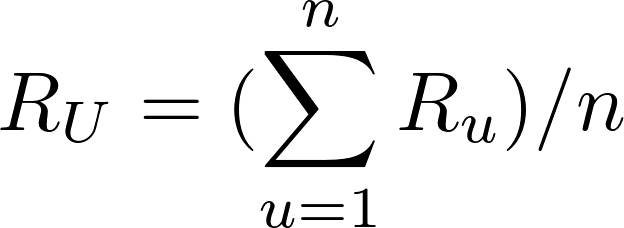

No caso de não haver tanta similaridade, podemos usar o Rating relativo

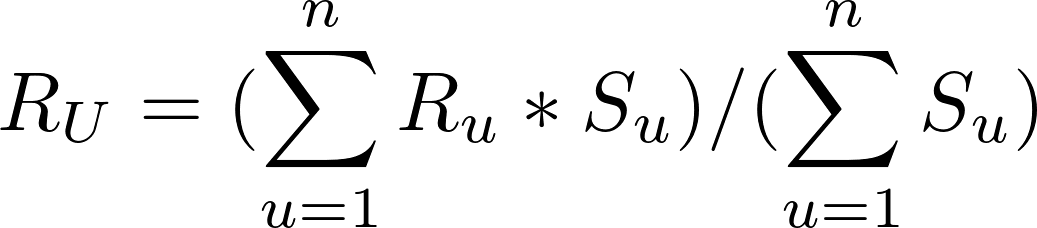

Ao multiplicar pelo fator de similaridade, você adiciona pesos às classificações. Quanto mais pesado o peso, mais a classificação importaria.

<h4>Mahalanobis distance

    1. It transforms the columns into uncorrelated variables
    2. Scale the columns to make their variance equal to 1
    3. Finally, it calculates the Euclidean distance.

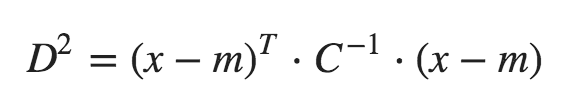

<H1> Teste com os dados do Movie Lens

In [8]:
df = pd.read_csv('ml-100k/u.data', sep = '\t',header = None, names = ['user_id','item_id', 'rating', 'timestamp'])

In [9]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Falando sobre modelos de recomendação temos duas abordagens:
    
The two approaches are mathematically quite similar, but there is a conceptual difference between the two. Here’s how the two compare:

User-based: For a user U, with a set of similar users determined based on rating vectors consisting of given item ratings, the rating for an item I, which hasn’t been rated, is found by picking out N users from the similarity list who have rated the item I and calculating the rating based on these N ratings.

Item-based: For an item I, with a set of similar items determined based on rating vectors consisting of received user ratings, the rating by a user U, who hasn’t rated it, is found by picking out N items from the similarity list that have been rated by U and calculating the rating based on these N ratings.

<h2> Item-based

<H3> Pre Processing

In [84]:
def gera_matrix(df):
    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]
    n_items = df['item_id'].max()
    A = np.zeros((n_users,n_items))
    for line in df.itertuples():
        A[line[1]-1,line[2]-1] = line[3]
    return A

In [85]:
A = gera_matrix(df)
print("Original rating matrix : ",A)

Original rating matrix :  [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]


In [14]:
csr_sample = csr_matrix(A)

In [17]:
print(f'{csr_sample}')

  (0, 0)	5.0
  (0, 1)	3.0
  (0, 2)	4.0
  (0, 3)	3.0
  (0, 4)	3.0
  (0, 5)	5.0
  (0, 6)	4.0
  (0, 7)	1.0
  (0, 8)	5.0
  (0, 9)	3.0
  (0, 10)	2.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	3.0
  (0, 17)	4.0
  (0, 18)	5.0
  (0, 19)	4.0
  (0, 20)	1.0
  (0, 21)	4.0
  (0, 22)	4.0
  (0, 23)	3.0
  (0, 24)	4.0
  :	:
  (942, 738)	4.0
  (942, 755)	2.0
  (942, 762)	4.0
  (942, 764)	3.0
  (942, 784)	2.0
  (942, 793)	3.0
  (942, 795)	3.0
  (942, 807)	4.0
  (942, 815)	4.0
  (942, 823)	4.0
  (942, 824)	3.0
  (942, 830)	2.0
  (942, 839)	4.0
  (942, 927)	5.0
  (942, 940)	1.0
  (942, 942)	5.0
  (942, 1010)	2.0
  (942, 1027)	2.0
  (942, 1043)	3.0
  (942, 1046)	2.0
  (942, 1066)	2.0
  (942, 1073)	4.0
  (942, 1187)	3.0
  (942, 1227)	3.0
  (942, 1329)	3.0


In [51]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=2, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=2)

Selecionando os Itens do usuário a ser predito

In [52]:
df.sort_values(['user_id', 'timestamp'], ascending=[True, False])

,user_id,item_id,rating,timestamp
3248,1,74,1,889751736
19699,1,102,2,889751736
30479,1,256,4,889751712
47638,1,5,3,889751712
687,1,171,5,889751711
...,...,...,...,...
89206,943,100,5,875501725
80079,943,174,4,875410099
73174,943,181,4,875409978
93735,943,28,4,875409978


In [53]:
df_sort_des[(df_sort_des['user_id'] == 1) & (df_sort_des['rating'] > 3)]

,user_id,item_id,rating,timestamp
30479,1,256,4,889751712
687,1,171,5,889751711
88259,1,111,5,889751711
10922,1,242,5,889751633
25255,1,32,5,888732909
...,...,...,...,...
22971,1,166,5,874965677
48214,1,156,4,874965556
74577,1,165,5,874965518
59972,1,168,5,874965478


In [54]:
df_sort_des = df.sort_values(['user_id', 'timestamp'], ascending=[True, False])
filter1 = df_sort_des[(df_sort_des['user_id'] == 1) & (df_sort_des['rating'] > 3)].item_id
filter1 = filter1.tolist()
filter1 = filter1[:10]
print(f'10 primeiros items que o usuário classificou: {filter1}')

10 primeiros items que o usuário classificou: [256, 171, 111, 242, 32, 209, 270, 18, 6, 221]


In [55]:
distances , indices = knn.kneighbors(csr_sample[1],n_neighbors=4)
print(f'Distancia entre recomendação e o filme escolhido {distances}')
print(f'Indice do filme recomendado {indices}')

Distancia entre recomendação e o filme escolhido [[1.11022302e-16 4.19364279e-01 4.87527093e-01 4.95582197e-01]]
Indice do filme recomendado [[  1 700 930 459]]


Recomendando 1 Item para cada item que o Usuário gostou

In [56]:
distances1=[]
indices1=[]
for i in filter1:
  distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=2)
  indices = indices.flatten()
  indices= indices[1:]
  indices1.extend(indices)
print(f'Items to be recommended: {indices1}')

Items to be recommended: [883, 436, 615, 105, 501, 642, 473, 578, 649, 681]


<h4> Testes de Valores

In [70]:
user_liked = df[(df['user_id'] == 1) & (df['item_id'].isin(filter1))]
user_liked

,user_id,item_id,rating,timestamp
687,1,171,5,889751711
3431,1,221,5,887431921
5533,1,6,5,887431973
8737,1,209,4,888732908
10922,1,242,5,889751633
25255,1,32,5,888732909
27216,1,270,5,888732827
30479,1,256,4,889751712
87831,1,18,4,887432020
88259,1,111,5,889751711


In [71]:
rec_movies = df[(df['item_id'].isin(indices1))].groupby('item_id').mean()['rating'].reset_index()
rec_movies

,item_id,rating
0,105,2.567568
1,436,3.535354
2,473,3.126984
3,501,3.495935
4,578,3.152174
5,615,4.050847
6,642,3.483146
7,649,3.400000
8,681,2.444444
9,883,3.230769


In [72]:
df_movies = pd.read_csv('ml-100k/u.item', sep = '|', encoding='latin-1',header = None, names = ['item_id' , 'movie_title' , 'release_date' , 'video_release_date' ,
              'IMDb_URL' , 'unknown' , 'Action' , 'Adventure' , 'Animation' ,
              'Childrens' , 'Comedy' , 'Crime' , 'Documentary' , 'Drama' , 'Fantasy' ,
              'Film_Noir' , 'Horror' , 'Musical' , 'Mystery' , 'Romance' , 'Sci-Fi' ,
              'Thriller' , 'War' , 'Western'])

In [73]:
df_names = df_movies[["item_id","movie_title"]]

In [74]:
user_liked.merge(df_names,on="item_id",how='left' )

,user_id,item_id,rating,timestamp,movie_title
0,1,171,5,889751711,Delicatessen (1991)
1,1,221,5,887431921,Breaking the Waves (1996)
2,1,6,5,887431973,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
3,1,209,4,888732908,This Is Spinal Tap (1984)
4,1,242,5,889751633,Kolya (1996)
5,1,32,5,888732909,Crumb (1994)
6,1,270,5,888732827,Gattaca (1997)
7,1,256,4,889751712,When the Cats Away (Chacun cherche son chat) (...
8,1,18,4,887432020,"White Balloon, The (1995)"
9,1,111,5,889751711,"Truth About Cats & Dogs, The (1996)"


In [75]:
rec_movies.merge(df_names,on="item_id",how='left' )

,item_id,rating,movie_title
0,105,2.567568,Sgt. Bilko (1996)
1,436,3.535354,"American Werewolf in London, An (1981)"
2,473,3.126984,James and the Giant Peach (1996)
3,501,3.495935,Dumbo (1941)
4,578,3.152174,Demolition Man (1993)
5,615,4.050847,"39 Steps, The (1935)"
6,642,3.483146,"Grifters, The (1990)"
7,649,3.400000,Once Upon a Time in America (1984)
8,681,2.444444,Wishmaster (1997)
9,883,3.230769,Telling Lies in America (1997)


<h4> Tratamento extra

Vamos mudar a ideia, e colocar apenas a classificação binária de gostou (4,5) e não gostou (1,2,3)

In [86]:
df2 = df.copy()

In [88]:
df2['rating'] = df2['rating'].apply(lambda x : 0 if x <= 3 else 1)
df2

,user_id,item_id,rating,timestamp
0,196,242,0,881250949
1,186,302,0,891717742
2,22,377,0,878887116
3,244,51,0,880606923
4,166,346,0,886397596
...,...,...,...,...
99995,880,476,0,880175444
99996,716,204,1,879795543
99997,276,1090,0,874795795
99998,13,225,0,882399156


In [89]:
csr_binary =csr_matrix(gera_matrix(df2))

In [90]:
print(f'{csr_binary}')

  (0, 0)	1.0
  (0, 2)	1.0
  (0, 5)	1.0
  (0, 6)	1.0
  (0, 8)	1.0
  (0, 11)	1.0
  (0, 12)	1.0
  (0, 13)	1.0
  (0, 14)	1.0
  (0, 15)	1.0
  (0, 17)	1.0
  (0, 18)	1.0
  (0, 19)	1.0
  (0, 21)	1.0
  (0, 22)	1.0
  (0, 24)	1.0
  (0, 27)	1.0
  (0, 31)	1.0
  (0, 32)	1.0
  (0, 38)	1.0
  (0, 41)	1.0
  (0, 42)	1.0
  (0, 43)	1.0
  (0, 44)	1.0
  (0, 45)	1.0
  :	:
  (942, 484)	1.0
  (942, 507)	1.0
  (942, 525)	1.0
  (942, 540)	1.0
  (942, 545)	1.0
  (942, 558)	1.0
  (942, 565)	1.0
  (942, 575)	1.0
  (942, 580)	1.0
  (942, 613)	1.0
  (942, 654)	1.0
  (942, 671)	1.0
  (942, 684)	1.0
  (942, 716)	1.0
  (942, 720)	1.0
  (942, 731)	1.0
  (942, 738)	1.0
  (942, 762)	1.0
  (942, 807)	1.0
  (942, 815)	1.0
  (942, 823)	1.0
  (942, 839)	1.0
  (942, 927)	1.0
  (942, 942)	1.0
  (942, 1073)	1.0


In [91]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=2, n_jobs=-1)
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=2)

Selecionando os Itens do usuário a ser predito

In [92]:
df2.sort_values(['user_id', 'timestamp'], ascending=[True, False])

,user_id,item_id,rating,timestamp
3248,1,74,0,889751736
19699,1,102,0,889751736
30479,1,256,1,889751712
47638,1,5,0,889751712
687,1,171,1,889751711
...,...,...,...,...
89206,943,100,1,875501725
80079,943,174,1,875410099
73174,943,181,1,875409978
93735,943,28,1,875409978


In [94]:
df2.sort_values(['user_id', 'timestamp'], ascending=[True, False])[(df2.sort_values(['user_id', 'timestamp'], ascending=[True, False])['user_id'] == 1)]

,user_id,item_id,rating,timestamp
3248,1,74,0,889751736
19699,1,102,0,889751736
30479,1,256,1,889751712
47638,1,5,0,889751712
687,1,171,1,889751711
...,...,...,...,...
22971,1,166,1,874965677
48214,1,156,1,874965556
74577,1,165,1,874965518
59972,1,168,1,874965478


In [95]:
df_sort_bin = df2.sort_values(['user_id', 'timestamp'], ascending=[True, False])
filter2 = df_sort_bin[(df_sort_bin['user_id'] == 1)].item_id
filter2 = filter2.tolist()
filter2 = filter2[:10]
print(f'10 primeiros items que o usuário classificou: {filter2}')

10 primeiros items que o usuário classificou: [74, 102, 256, 5, 171, 111, 242, 189, 32, 209]


In [96]:
distances , indices = knn.kneighbors(csr_binary[1],n_neighbors=4)
print(f'Distancia entre recomendação e o filme escolhido {distances}')
print(f'Indice do filme recomendado {indices}')

Distancia entre recomendação e o filme escolhido [[0.09719331 0.43981613 0.50792962 0.52826777]]
Indice do filme recomendado [[  1 700 930 412]]


Recomendando 1 Item para cada item que o Usuário gostou

In [105]:
distances2=[]
indices2=[]
for i in filter2:
  distances , indices = knn.kneighbors(csr_binary[i],n_neighbors=2)
  indices = indices.flatten()
  indices= indices[1:]
  indices2.extend(indices)
print(f'Items to be recommended: {indices2}')

Items to be recommended: [517, 648, 448, 320, 114, 615, 105, 833, 501, 312]


<h4> Testes de Valores

In [100]:
user_liked2 = df[(df['user_id'] == 1) & (df['item_id'].isin(filter2))]
user_liked2

,user_id,item_id,rating,timestamp
305,1,189,3,888732928
687,1,171,5,889751711
3248,1,74,1,889751736
8737,1,209,4,888732908
10922,1,242,5,889751633
19699,1,102,2,889751736
25255,1,32,5,888732909
30479,1,256,4,889751712
47638,1,5,3,889751712
88259,1,111,5,889751711


In [101]:
rec_movies2 = df[(df['item_id'].isin(indices2))].groupby('item_id').mean()['rating'].reset_index()
rec_movies2

,item_id,rating
0,105,2.567568
1,114,4.447761
2,312,3.162500
3,320,4.050000
4,448,3.388235
5,501,3.495935
6,517,3.769231
7,615,4.050847
8,648,4.029851
9,833,3.204082


In [102]:
user_liked2.merge(df_names,on="item_id",how='left' )

,user_id,item_id,rating,timestamp,movie_title
0,1,189,3,888732928,"Grand Day Out, A (1992)"
1,1,171,5,889751711,Delicatessen (1991)
2,1,74,1,889751736,Faster Pussycat! Kill! Kill! (1965)
3,1,209,4,888732908,This Is Spinal Tap (1984)
4,1,242,5,889751633,Kolya (1996)
5,1,102,2,889751736,"Aristocats, The (1970)"
6,1,32,5,888732909,Crumb (1994)
7,1,256,4,889751712,When the Cats Away (Chacun cherche son chat) (...
8,1,5,3,889751712,Copycat (1995)
9,1,111,5,889751711,"Truth About Cats & Dogs, The (1996)"


In [103]:
rec_movies2.merge(df_names,on="item_id",how='left' )

,item_id,rating,movie_title
0,105,2.567568,Sgt. Bilko (1996)
1,114,4.447761,Wallace & Gromit: The Best of Aardman Animatio...
2,312,3.162500,Midnight in the Garden of Good and Evil (1997)
3,320,4.050000,Paradise Lost: The Child Murders at Robin Hood...
4,448,3.388235,"Omen, The (1976)"
5,501,3.495935,Dumbo (1941)
6,517,3.769231,Manhattan (1979)
7,615,4.050847,"39 Steps, The (1935)"
8,648,4.029851,"Quiet Man, The (1952)"
9,833,3.204082,Bulletproof (1996)


<h2> User-based

In [81]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [83]:
# Create user-item matrix
matrix = df.pivot_table(index='user_id', columns='item_id', values='rating')
matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.389706,-0.610294,0.389706,-0.610294,-0.610294,1.389706,0.389706,-2.610294,1.389706,-0.610294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.709677,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.125714,0.125714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
pd.DataFrame(cosine_similarity(matrix_norm.fillna(0)))

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,1.000000,0.043411,0.011051,0.059303,0.134514,0.103373,0.110556,0.180891,0.012253,-0.000621,...,0.025835,-0.047952,0.087224,0.007718,0.074378,0.078714,0.067433,0.028790,-0.031270,0.032123
1,0.043411,1.000000,0.013658,-0.017016,0.035770,0.094503,0.089408,0.055640,0.027294,0.097846,...,0.012853,-0.028798,0.056659,0.197835,0.090009,0.032505,0.015053,-0.017344,0.012068,0.039173
2,0.011051,0.013658,1.000000,-0.059638,0.016037,-0.017158,0.016141,0.041177,-0.010093,0.023856,...,0.001615,0.000658,-0.006888,0.036157,-0.018513,-0.006240,-0.023907,0.034414,-0.009187,0.001489
3,0.059303,-0.017016,-0.059638,1.000000,0.007373,-0.053929,-0.025604,0.136046,0.016082,-0.013588,...,0.011895,0.002174,-0.028000,-0.025021,0.022882,-0.005960,0.279818,0.258594,0.064504,-0.019222
4,0.134514,0.035770,0.016037,0.007373,1.000000,0.038484,0.067874,0.140106,0.010195,0.014335,...,0.070014,-0.070821,0.024278,0.038672,0.093567,0.051782,0.029540,0.036234,0.043318,0.099324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,0.078714,0.032505,-0.006240,-0.005960,0.051782,-0.047520,0.013584,0.025026,0.018475,0.014387,...,0.032608,-0.004944,0.064036,-0.035230,0.019929,1.000000,0.016835,-0.030376,-0.023190,0.004451
939,0.067433,0.015053,-0.023907,0.279818,0.029540,-0.012071,0.005844,0.078222,0.004491,0.044572,...,-0.029460,0.054646,-0.059929,-0.032935,0.022646,0.016835,1.000000,0.102008,-0.011483,0.065414
940,0.028790,-0.017344,0.034414,0.258594,0.036234,0.001559,0.001943,0.057949,0.040748,0.026179,...,-0.025764,-0.031663,0.057585,0.094183,-0.094838,-0.030376,0.102008,1.000000,-0.019055,0.000666
941,-0.031270,0.012068,-0.009187,0.064504,0.043318,0.036605,0.106252,0.030609,0.026259,0.062067,...,0.114179,-0.035153,-0.002613,0.031585,0.007572,-0.023190,-0.011483,-0.019055,1.000000,0.040354


In [109]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.00000000e+00,  4.34108342e-02,  1.10508910e-02, ...,
         2.87902189e-02, -3.12704963e-02,  3.21234686e-02],
       [ 4.34108342e-02,  1.00000000e+00,  1.36577422e-02, ...,
        -1.73443333e-02,  1.20678821e-02,  3.91732571e-02],
       [ 1.10508910e-02,  1.36577422e-02,  1.00000000e+00, ...,
         3.44144054e-02, -9.18699063e-03,  1.48879883e-03],
       ...,
       [ 2.87902189e-02, -1.73443333e-02,  3.44144054e-02, ...,
         1.00000000e+00, -1.90550456e-02,  6.66444773e-04],
       [-3.12704963e-02,  1.20678821e-02, -9.18699063e-03, ...,
        -1.90550456e-02,  1.00000000e+00,  4.03538399e-02],
       [ 3.21234686e-02,  3.91732571e-02,  1.48879883e-03, ...,
         6.66444773e-04,  4.03538399e-02,  1.00000000e+00]])